In [2]:
from hybridSVD import hsvd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download and Read Data

In [3]:
ratings = pd.read_csv('ratings.dat', sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])

C:\Users\Mekan\AppData\Local\Temp\ipykernel_8048\1000372124.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('ratings.dat', sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])


In [4]:
movies = pd.read_csv('movies.dat', sep='::',names=['movieid', 'title', 'genres'],
                              encoding='ascii',encoding_errors='replace') # some issue in line 3114

C:\Users\Mekan\AppData\Local\Temp\ipykernel_8048\3355831243.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('movies.dat', sep='::',names=['movieid', 'title', 'genres'],


In [5]:
movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Preprocessing

In [6]:
#encode genres
movies['genres'] = movies['genres'].apply(lambda x: str(x).split('|'))
all_genres = set(list(movies['genres'].sum()))
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: genre in x).astype(int)

In [7]:
users = pd.read_csv('users.dat', sep='::', names=['userid', 'gender', 'age', 'occupation', 'zip-code'])

C:\Users\Mekan\AppData\Local\Temp\ipykernel_8048\3257079460.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('users.dat', sep='::', names=['userid', 'gender', 'age', 'occupation', 'zip-code'])


In [8]:
users.head()

,userid,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [9]:
occupations_dict = {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}
users['occupation'] = users['occupation'].apply(lambda x: occupations_dict[x])
occupations_dummies = pd.get_dummies(users['occupation'])
age_dummies = pd.get_dummies(users['age'],prefix='age')
users['gender'] = users['gender'].apply(lambda x: 1 if x=='M' else 0)
users = pd.concat([users, occupations_dummies, age_dummies], axis=1)


# Split Data and Re-index

In [10]:
from dataprep import generate_interactions_matrix, reindex_data, transform_indices, timepoint_split

In [11]:
training_ , testset_ , holdout_ = timepoint_split(ratings, time_split_q=0.99)
training_.shape, testset_ .shape, holdout_.shape

((858241, 4), (131944, 4), (347, 4))

In [12]:
training , data_index = transform_indices(training_ , 'userid', 'movieid')
# train = reindex_data(train_, data_index)
# testset_ = testset.query('movieid in @cold_items')
testset = reindex_data(testset_, data_index, fields='items')
holdout = reindex_data(holdout_, data_index, fields='items')
testset = testset.query('userid >= 0')
training.shape, testset.shape, holdout.shape

((858241, 4), (131944, 4), (347, 4))

In [13]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    user_index = data_index['users'],
    item_index = data_index['items']
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 5692,
 'n_items': 3687,
 'user_index': Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
             ...
             6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
            dtype='int64', name='userid', length=5692),
 'item_index': Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
             ...
             3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
            dtype='int64', name='movieid', length=3687)}

# Build Side Features Matrix

In [14]:
movie_features_ = movies.drop(['title', 'genres'],axis=1)
movie_features = reindex_data(movie_features_, data_index, fields='items')

In [15]:
movie_features = movie_features.query('movieid >= 0').sort_values(by='movieid')

In [16]:
item_features_mtx = movie_features.iloc[:,1:].values.astype(float).T

In [17]:
item_features_mtx.shape

(18, 3687)

In [18]:
user_features_ = users.drop(['age', 'occupation', 'zip-code'], axis=1)
user_features = reindex_data(user_features_, data_index, fields='users')

In [19]:
user_features = user_features.query('userid >= 0')

In [20]:
user_features_mtx = user_features.iloc[:,1:].values.astype(float)
user_features_mtx.shape

(5692, 29)

# Apply First Hypothesis for feature importance

## PureSVD for feature compression
$$
U, s, V = \text{svd}(F_I) \\ 
I_1 = \text{maxvol}(U)
$$

In [21]:
U, S = hsvd(item_features_mtx, 
             ret='left'
             )

In [22]:
from maxvol import maxvol, maxvol_rect
H1_item_features_importance, _ = maxvol_rect(U[:-1,:].T,dr_min=1)
print(H1_item_features_importance)

[12  9 15  5 11  0 16  2  8  4  6  1 13 14  3 17 10  7]


## Hypothesis 1 (HybridSVD for item feature compression, enhanced by items similarity in the collaborative space)
$$
S_I = \text{CosineSimilarity}(A^T) \\
U, s, V = \text{hsvd}(F_I, \text{RightSim}=S_I, \beta) \\ 
I_2 = \text{maxvol}(U)
$$

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
A = generate_interactions_matrix(training, data_description)

In [25]:
S_I = cosine_similarity(A.T,dense_output=False)
S_I.setdiag(0)

In [26]:
U2, S = hsvd(item_features_mtx, 
             right_similarity= S_I,
             beta= 0,
             ret='left'
             )

In [27]:
H2_item_features_importance, _ = maxvol_rect(U2[:-1,:].T,dr_min=1)
print(H2_item_features_importance)

[12  9 15  5 11  0 16  2  8  4  6  1 13 14  3 17 10  7]


In [28]:
betas = np.linspace(0,0.4,21)
beta_vs_importance= np.empty((U.shape[0],len(betas)))
for i in range(len(betas)):
    U2, S = hsvd(item_features_mtx, 
             right_similarity= S_I,
             beta= betas[i],
             ret='left'
             )
    beta_vs_importance[:,i], _ = maxvol_rect(U2[:-1,:].T,dr_min=1)

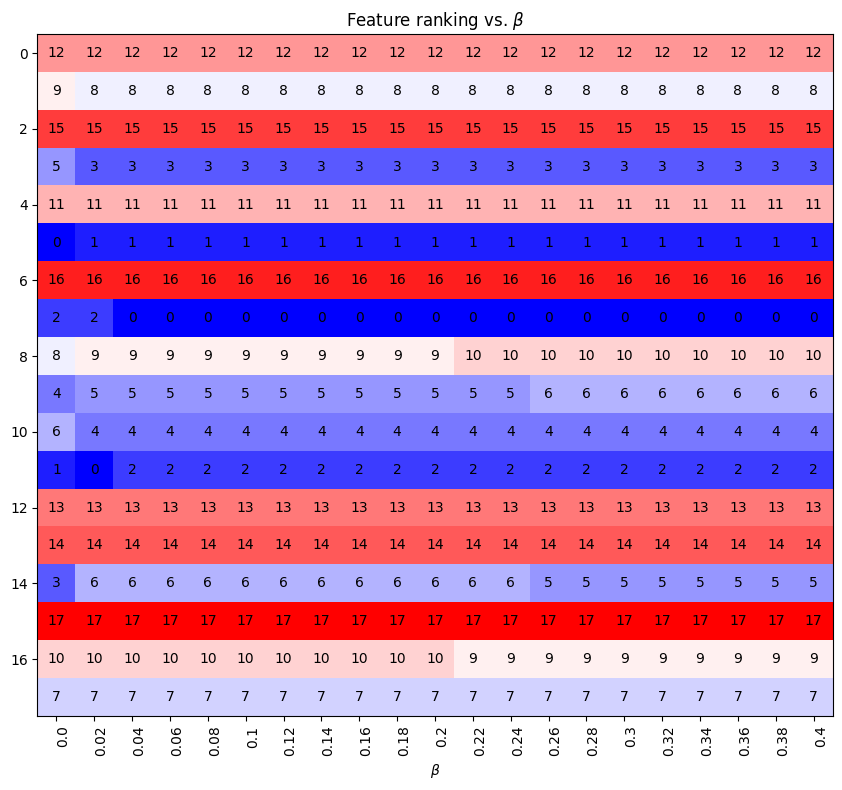

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(beta_vs_importance, cmap='bwr')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(betas)), labels=betas)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(H1_item_features_importance)):
    for j in range(len(betas)):
        text = ax.text(j, i, int(beta_vs_importance[i, j]),
                       ha="center", va="center", color="k")

ax.set_title(r"Feature ranking vs. $\beta$")
ax.set_xlabel(r'$\beta$')
fig.tight_layout()
plt.show()

# Hypothesis 2

$$
B = A F_I^T \\
S_I = \text{CosineSimilarity}(B^T) \\
U, s, V = \text{hsvd}(F_I, \text{LeftSim}=S_I, \alpha) \\ 
I_3 = \text{maxvol}(U)
$$

In [30]:
A.shape

(5692, 3687)

In [31]:
item_features_mtx.shape

(18, 3687)

In [32]:
B = A.dot(item_features_mtx.T)

In [33]:
S_h = cosine_similarity(B.T)

In [34]:
S_h.shape

(18, 18)

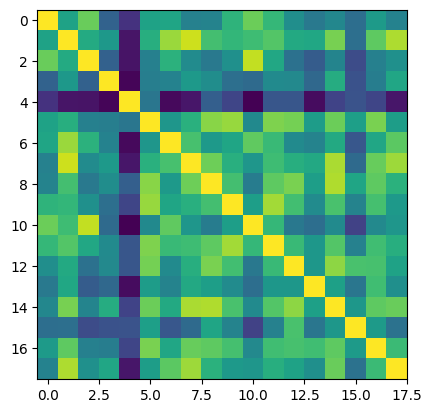

In [35]:
plt.imshow(S_h)

In [36]:
np.fill_diagonal(S_h, 0)

In [37]:
U3, S3 = hsvd(item_features_mtx, 
             left_similarity= S_h,
             alpha= 0.1,
             ret='left'
             )

In [38]:
U3.shape

(18, 18)

In [39]:
H3_item_features_importance, _ = maxvol_rect(U3[:-1,:].T,dr_min=1)
print(H3_item_features_importance)

[12  9 15  5 11  1 16  6  8  4  3  0 13 14  2 17 10  7]


# Testing Hypothesis

In [40]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from evaluation import topn_recommendations, topidx, downvote_seen_items
def hsvd_svd_recs(item_factors, testset, testset_description, topn = 10):
    recs = {} 
    gp = testset.groupby(testset_description['users'])[
        testset_description['items'],testset_description['feedback']
        ].agg(list)
    for userid, items, ratings in gp.itertuples(name=None):
        ratings = np.array(ratings)
        rated_items = ratings.dot(item_factors[items])
        scores = item_factors.dot(rated_items)
        scores[items] = scores.min() - 1
        # print(scores.shape)
        idx = topidx(scores, topn)
        recs[userid] = list(testset_description['user_index'][idx])
    return recs

In [41]:
def model_evaluate(recommended_users, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_users.shape[0] == len(holdout_items)
    hits_mask = recommended_users[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_users.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_users = holdout_description['n_users']
    cov = np.unique(recommended_users).size / n_users
    return hr, mrr, cov

In [42]:
from tqdm import tqdm
def test_hypo(config, h_importance, topn = 10):
    rank = config['rank']
    beta = config['beta']
    n_F = len(h_importance)
    hr = np.empty((n_F+1))
    mrr = np.empty((n_F+1))
    cov = np.empty((n_F+1))

    _, item_factors = hsvd(A.A, rank=-1, ret='right', beta=beta)
    recs = hsvd_svd_recs(item_factors, testset, data_description, topn)
    recommended_items = np.array(list(recs.values()))
    hr[0], mrr[0], cov[0] = model_evaluate(recommended_items, holdout, data_description, topn)

    for i in tqdm(range(1,n_F+1)):
        F_I = item_features_mtx[h_importance[:i],:]
        S_F = cosine_similarity(F_I.T, dense_output=True)
        np.fill_diagonal(S_F, 0)
        _, item_factors = hsvd(A.A, rank=rank, right_similarity=S_F, beta=beta, ret='right')
        recs = hsvd_svd_recs(item_factors, testset, data_description, topn)
        recommended_items = np.array(list(recs.values()))
        hr[i], mrr[i], cov[i] = model_evaluate(recommended_items, holdout, data_description, topn)
    return hr, mrr, cov
        

In [43]:
config1 = dict(
    rank = 100,
    beta = 0
)

In [44]:
hr1, mrr1, cov1 = test_hypo(config1, H1_item_features_importance)

100%|██████████| 18/18 [24:59<00:00, 83.31s/it]


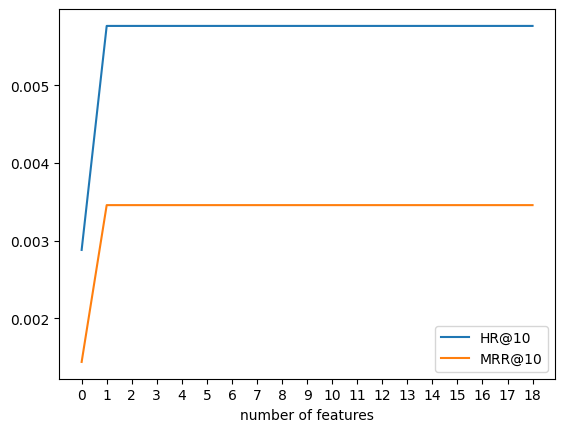

In [45]:
plt.plot(hr1,label='HR@10')
plt.plot(mrr1, label='MRR@10')
plt.xlabel('number of features')
plt.xticks(np.arange(len(H1_item_features_importance)+1))
plt.legend()

In [55]:
np.arange(0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [56]:
config = dict(
    rank = 100,
    beta = 0.3
)

Different Beta

In [66]:
config20 = dict(
    rank = 100,
    beta = 0
)

config21 = dict(
    rank = 100,
    beta = 0.1
)

config22 = dict(
    rank = 100,
    beta = 0.2
)

config23 = dict(
    rank = 100,
    beta = 0.3
)

config24 = dict(
    rank = 100,
    beta = 0.4
)

In [67]:
hr20, mrr20, cov20 = test_hypo(config20, H2_item_features_importance)
hr21, mrr21, cov21 = test_hypo(config21, H2_item_features_importance)
hr22, mrr22, cov22 = test_hypo(config22, H2_item_features_importance)
hr23, mrr23, cov23 = test_hypo(config23, H2_item_features_importance)
hr24, mrr24, cov24 = test_hypo(config24, H2_item_features_importance)

100%|██████████| 18/18 [25:03<00:00, 83.52s/it] 


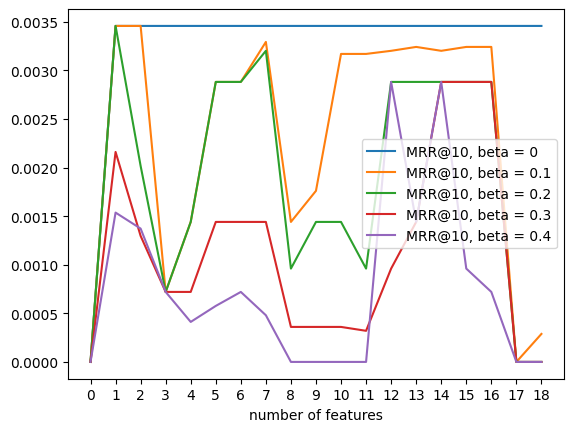

In [73]:
# plt.plot(hr20, label='HR@10')
# plt.plot(hr21, label='HR@10')
# plt.plot(hr22, label='HR@10')
# plt.plot(hr23, label='HR@10')
# plt.plot(hr24, label='HR@10')
plt.plot(mrr20, label='MRR@10, beta = 0')
plt.plot(mrr21, label='MRR@10, beta = 0.1')
plt.plot(mrr22, label='MRR@10, beta = 0.2')
plt.plot(mrr23, label='MRR@10, beta = 0.3')
plt.plot(mrr24, label='MRR@10, beta = 0.4')
plt.xlabel('number of features')
plt.xticks(np.arange(len(H2_item_features_importance)+1))
plt.legend()

In [74]:
hr30, mrr30, cov30 = test_hypo(config20, H3_item_features_importance)
hr31, mrr31, cov31 = test_hypo(config21, H3_item_features_importance)
hr32, mrr32, cov32 = test_hypo(config22, H3_item_features_importance)
hr33, mrr33, cov33 = test_hypo(config23, H3_item_features_importance)
hr34, mrr34, cov34 = test_hypo(config24, H3_item_features_importance)

100%|██████████| 18/18 [21:32<00:00, 71.83s/it]


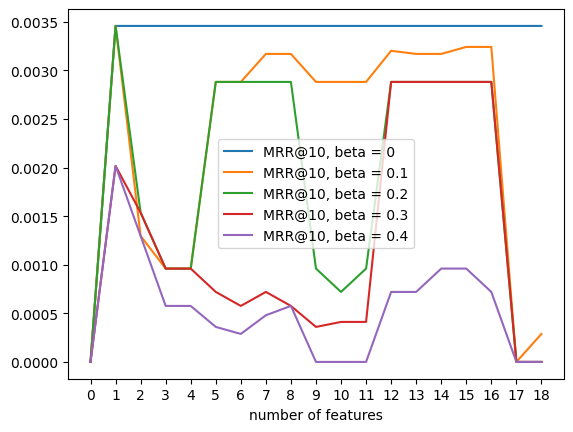

In [75]:
plt.plot(mrr30, label='MRR@10, beta = 0')
plt.plot(mrr31, label='MRR@10, beta = 0.1')
plt.plot(mrr32, label='MRR@10, beta = 0.2')
plt.plot(mrr33, label='MRR@10, beta = 0.3')
plt.plot(mrr34, label='MRR@10, beta = 0.4')
plt.xlabel('number of features')
plt.xticks(np.arange(len(H3_item_features_importance)+1))
plt.legend()

## Hypothesis 3 (HybridSVD for user feature compression, enhanced by users similarity in the collaborative space)
$$
S_U = \text{CosineSimilarity}(A) \\
U, s, V = \text{hsvd}(F_U, \text{RightSim}=S_U, \beta) \\ 
I_2 = \text{maxvol}(U)
$$

In [41]:
S_U = cosine_similarity(A,dense_output=False)
S_U.setdiag(0)

In [80]:
betas = np.linspace(0,0.4,21)
beta_vs_importance_3= np.empty((29,len(betas)))
for i in range(len(betas)):
    U3, S = hsvd(user_features_mtx.T, 
             right_similarity= S_U,
             beta= betas[i],
             ret='left'
             )
    beta_vs_importance_3[:,i], _ = maxvol_rect(U3[:-1,:].T,dr_min=1)

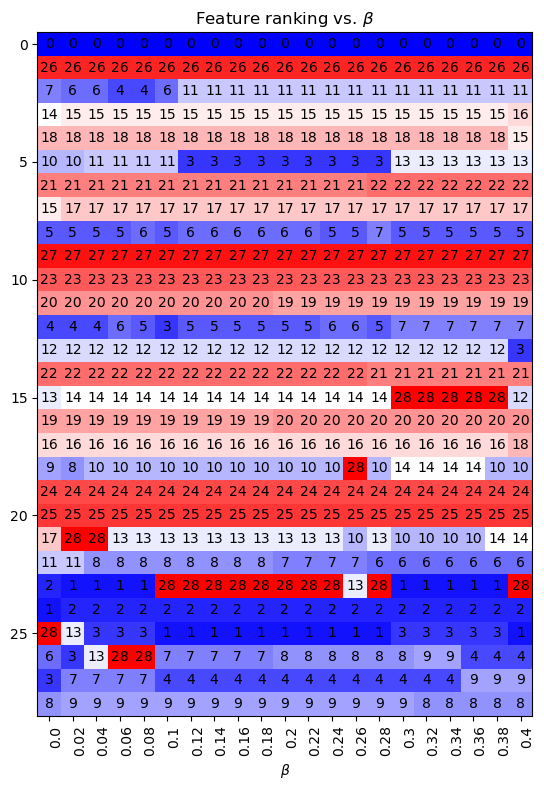

In [81]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(beta_vs_importance_3, cmap='bwr')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(betas)), labels=betas)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(beta_vs_importance_3.shape[0]):
    for j in range(len(betas)):
        text = ax.text(j, i, int(beta_vs_importance_3[i, j]),
                       ha="center", va="center", color="k")

ax.set_title(r"Feature ranking vs. $\beta$")
ax.set_xlabel(r'$\beta$')
fig.tight_layout()
plt.show()

In [83]:
U3, S = hsvd(user_features_mtx.T, 
             right_similarity= S_U,
             beta= 0.2,
             ret='left'
             )
H3_user_features_importance, _ = maxvol_rect(U3[:-1,:].T,dr_min=1)
print(H3_user_features_importance)

[ 0 26 11 15 18  3 21 17  6 27 23 19  5 12 22 14 20 16 10 24 25 13  7 28
  2  1  8  4  9]


 0 26 11 15 18 13 22 17  5 27 23 19  7 12 21 28 20 16 14 24 25 10  6  1 2  3  8  4  9

# Testing Hypothesis

In [42]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from evaluation import topn_recommendations, topidx, downvote_seen_items
def hsvd_svd_recs(item_factors, testset, testset_description, topn = 10):
    recs = {} 
    gp = testset.groupby(testset_description['users'])[
        testset_description['items'],testset_description['feedback']
        ].agg(list)
    for userid, items, ratings in gp.itertuples(name=None):
        ratings = np.array(ratings)
        rated_items = ratings.dot(item_factors[items])
        scores = item_factors.dot(rated_items)
        scores[items] = scores.min() - 1
        # print(scores.shape)
        idx = topidx(scores, topn)
        recs[userid] = list(testset_description['user_index'][idx])
    return recs

In [43]:
def model_evaluate(recommended_users, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_users.shape[0] == len(holdout_items)
    hits_mask = recommended_users[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_users.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_users = holdout_description['n_users']
    cov = np.unique(recommended_users).size / n_users
    return hr, mrr, cov

In [44]:
from tqdm import tqdm
def test_hypo(config, h_importance, topn = 10):
    rank = config['rank']
    beta = config['beta']
    n_F = len(h_importance)
    hr = np.empty((n_F+1))
    mrr = np.empty((n_F+1))
    cov = np.empty((n_F+1))

    _, item_factors = hsvd(A.A, rank=-1, ret='right', beta=beta)
    recs = hsvd_svd_recs(item_factors, testset, data_description, topn)
    recommended_items = np.array(list(recs.values()))
    hr[0], mrr[0], cov[0] = model_evaluate(recommended_items, holdout, data_description, topn)

    for i in tqdm(range(1,n_F+1)):
        F_I = item_features_mtx[h_importance[:i],:]
        S_F = cosine_similarity(F_I.T, dense_output=True)
        np.fill_diagonal(S_F, 0)
        _, item_factors = hsvd(A.A, rank=rank, right_similarity=S_F, beta=beta, ret='right')
        recs = hsvd_svd_recs(item_factors, testset, data_description, topn)
        recommended_items = np.array(list(recs.values()))
        hr[i], mrr[i], cov[i] = model_evaluate(recommended_items, holdout, data_description, topn)
    return hr, mrr, cov
        

In [45]:
config = dict(
    rank = 100,
    beta = 0.3
)

In [82]:
hr, mrr, cov = test_hypo(config, H2_item_features_importance,20)

100%|██████████| 18/18 [06:14<00:00, 20.82s/it]


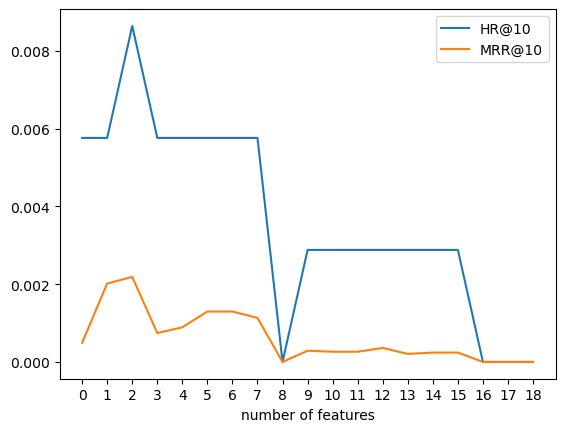

In [85]:
plt.plot(hr,label='HR@10')
plt.plot(mrr, label='MRR@10')
plt.xlabel('number of features')
plt.xticks(np.arange(len(H2_item_features_importance)+1))
plt.legend();

In [36]:



ranks = [16, 25, 32, 50, 64, 100, 128, 200]
betas = np.linspace(0,0.4,21)
h_importance = H2_item_features_importance
n_F = len(h_importance)
topn = 10
HR = np.empty((len(betas),len(ranks),len(H2_item_features_importance)+1))
MRR = np.empty_like(HR)
COV = np.empty_like(HR)

for i in range(len(betas)):
    print('##############', betas[i])
    for k in tqdm(range(1,n_F+1)):
        F_I = item_features_mtx[h_importance[:k],:]
        S_F = cosine_similarity(F_I.T, dense_output=True)
        np.fill_diagonal(S_F, 0)
        _, item_factors = hsvd(A.A, rank=-1, ret='right', beta=betas[i])
        for j in range(len(ranks)):
            recs = hsvd_svd_recs(item_factors[:,:ranks[j]], testset, data_description, topn)
            recommended_items = np.array(list(recs.values()))
            HR[i,j,k], MRR[i,j,k], COV[i,j,k]  = model_evaluate(recommended_items, holdout, data_description, topn)

############## 0.0


100%|██████████| 18/18 [05:46<00:00, 19.25s/it]


############## 0.02


100%|██████████| 18/18 [05:43<00:00, 19.08s/it]


############## 0.04


100%|██████████| 18/18 [05:09<00:00, 17.19s/it]


############## 0.06


100%|██████████| 18/18 [05:12<00:00, 17.38s/it]


############## 0.08


100%|██████████| 18/18 [05:12<00:00, 17.35s/it]


############## 0.1


100%|██████████| 18/18 [05:09<00:00, 17.22s/it]


############## 0.12


100%|██████████| 18/18 [05:13<00:00, 17.43s/it]


############## 0.14


100%|██████████| 18/18 [05:15<00:00, 17.54s/it]


############## 0.16


100%|██████████| 18/18 [05:06<00:00, 17.01s/it]


############## 0.18


100%|██████████| 18/18 [05:11<00:00, 17.30s/it]


############## 0.2


100%|██████████| 18/18 [05:11<00:00, 17.29s/it]


############## 0.22


100%|██████████| 18/18 [05:12<00:00, 17.35s/it]


############## 0.24


100%|██████████| 18/18 [05:12<00:00, 17.35s/it]


############## 0.26


100%|██████████| 18/18 [05:01<00:00, 16.74s/it]


############## 0.28


100%|██████████| 18/18 [05:02<00:00, 16.79s/it]


############## 0.3


100%|██████████| 18/18 [05:01<00:00, 16.73s/it]


############## 0.32


100%|██████████| 18/18 [05:05<00:00, 16.99s/it]


############## 0.34


100%|██████████| 18/18 [05:08<00:00, 17.15s/it]


############## 0.36


100%|██████████| 18/18 [05:12<00:00, 17.34s/it]


############## 0.38


100%|██████████| 18/18 [05:12<00:00, 17.37s/it]


############## 0.4


100%|██████████| 18/18 [05:12<00:00, 17.39s/it]


array([4.35780786e+265, 3.45821326e-003, 3.45821326e-003, 3.45821326e-003,
       3.45821326e-003, 3.45821326e-003, 3.45821326e-003, 3.45821326e-003,
       3.45821326e-003, 3.45821326e-003, 3.45821326e-003, 3.45821326e-003,
       3.45821326e-003, 3.45821326e-003, 3.45821326e-003, 3.45821326e-003,
       3.45821326e-003, 3.45821326e-003, 3.45821326e-003])